In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/'

SoFi_keys = ['Tinatinv4_2factor_profile', 'Tinatinv4_2factor_timeseries', 
             'KBHH2024v12_4factor_profile', 'KBHH2024v12_4factor_timeseries',
             'KBHH2024v15_5factor_profile', 'KBHH2024v15_5factor_timeseries']
Ref_keys = ['002_HOA', '011_HOA', '014_HOA', '003_OOA', '007_LO-OOA', '010_LO-OOA', '005_MO-OOA', '009_MO-OOA', '012_MO-OOA', '030_Birchen', '039_Oak', '041_Pinetree', '042_Poplar']
# 002_HOA is 001_HOA in database

SoFi = read_txt(f'{path}cph central and nørreport measurements/SoFi resultater/', parent_path, SoFi_keys, '\t', None)
for key in [key for key in SoFi_keys if 'timeseries' in key]:
    SoFi[key]['Time'] = pd.to_datetime(SoFi[key]['Time'])

    SoFi[key]['Date'] = SoFi[key]['Time'].dt.date
    for date in SoFi[key]['Date'].unique():
        mask = SoFi[key]['Date'] == date
        new_df = SoFi[key][mask].reset_index()
        name = key.split('_')[0]
        SoFi[f'{name}_{date}'] = new_df

Ref_MS = read_txt(f'{path}ref ms/txt files/', parent_path, Ref_keys, '\t', None)

In [3]:
print(SoFi.keys())

dict_keys(['Tinatinv4_2factor_profile', 'Tinatinv4_2factor_timeseries', 'KBHH2024v12_4factor_profile', 'KBHH2024v12_4factor_timeseries', 'KBHH2024v15_5factor_profile', 'KBHH2024v15_5factor_timeseries', 'Tinatinv4_2022-03-08', 'KBHH2024v12_2024-12-10', 'KBHH2024v12_2024-12-11', 'KBHH2024v12_2024-12-12', 'KBHH2024v12_2024-12-13', 'KBHH2024v15_2024-12-10', 'KBHH2024v15_2024-12-11', 'KBHH2024v15_2024-12-12', 'KBHH2024v15_2024-12-13'])


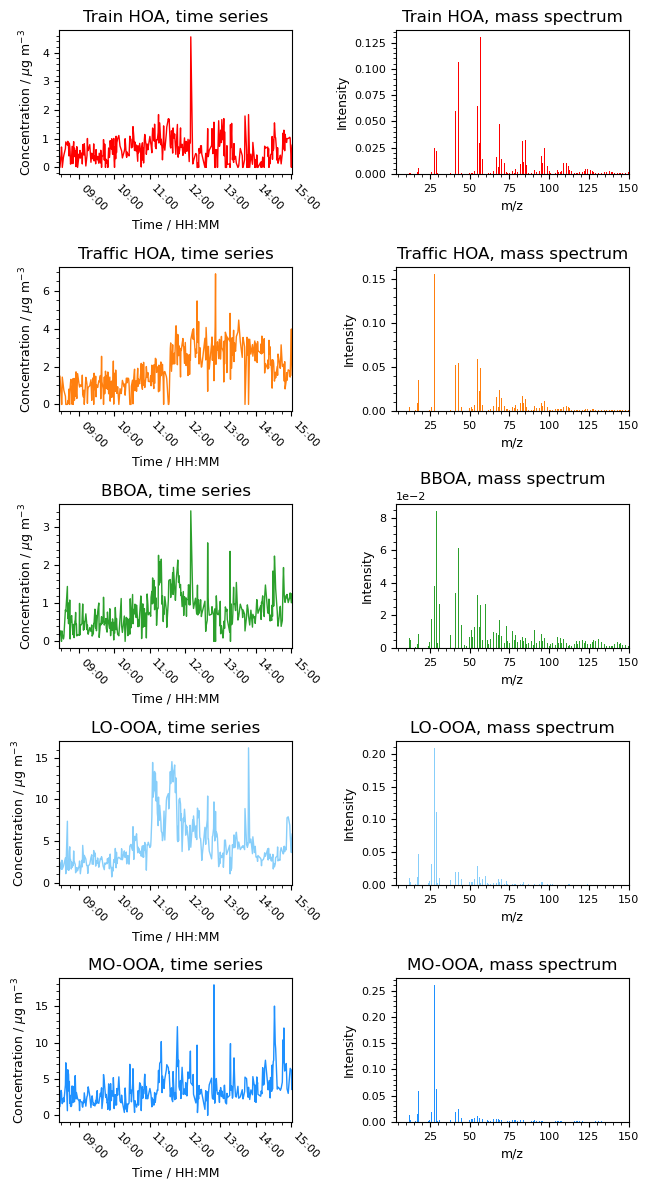

In [4]:
fig, ax = plt. subplots(5, 2, figsize = (6.7, 12))

colors = ['r', 'tab:orange', 'tab:green', 'lightskyblue', 'dodgerblue'] # Train HOA, Traffic HOA, BBOA, LO-OOA, MO-OOA
titles = ['Train HOA', 'Traffic HOA', 'BBOA', 'LO-OOA', 'MO-OOA']

for i in range(5):
    conc = f'Factor{i+1}'

    plot_total(ax[i][0], SoFi['KBHH2024v15_2024-12-11'], conc, colors[i], '-')
    ax[i][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = f'{titles[i]}, time series')
    plot_MS(ax[i][1], SoFi['KBHH2024v15_5factor_profile'], conc, 0.5, f'{titles[i]}, mass spectrum', colors[i])

fig.tight_layout()
fig.savefig('SoFi/KBHH2024v15_5factor_PMF.png', dpi = 600)
plt.show()

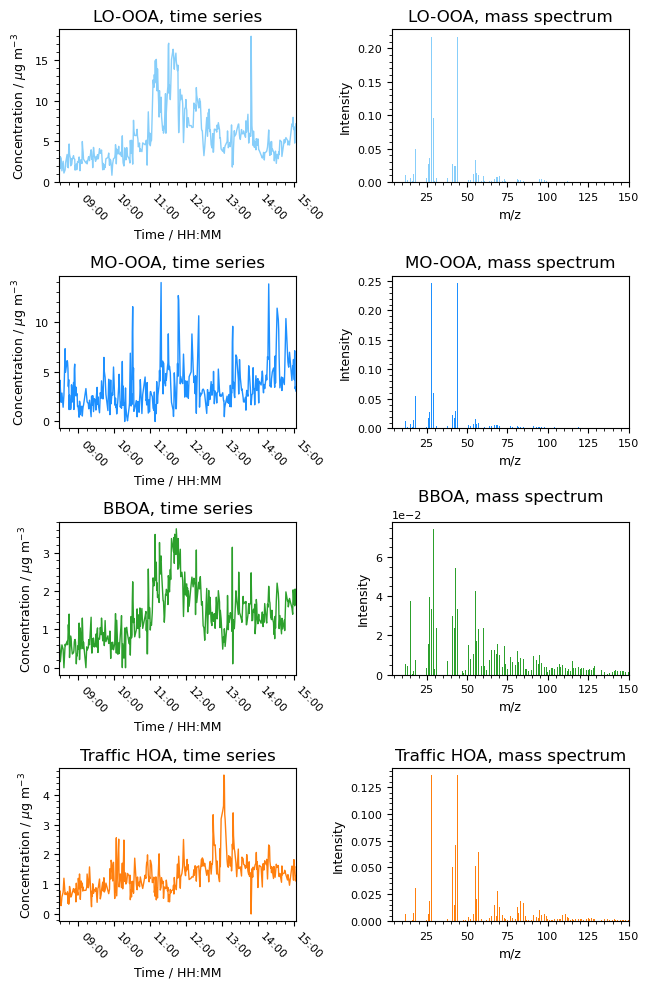

In [5]:
fig, ax = plt. subplots(4, 2, figsize = (6.7, 10))

colors = ['lightskyblue', 'dodgerblue', 'tab:green', 'tab:orange'] # Train HOA, Traffic HOA, BBOA, LO-OOA, MO-OOA
titles = ['LO-OOA', 'MO-OOA', 'BBOA', 'Traffic HOA']

for i in range(4):
    conc = f'Factor{i+1}'

    plot_total(ax[i][0], SoFi['KBHH2024v12_2024-12-11'], conc, colors[i], '-')
    ax[i][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = f'{titles[i]}, time series')
    plot_MS(ax[i][1], SoFi['KBHH2024v12_4factor_profile'], conc, 0.5, f'{titles[i]}, mass spectrum', colors[i])

fig.tight_layout()
fig.savefig('SoFi/KBHH2024v12_4factor_PMF.png', dpi = 600)
plt.show()

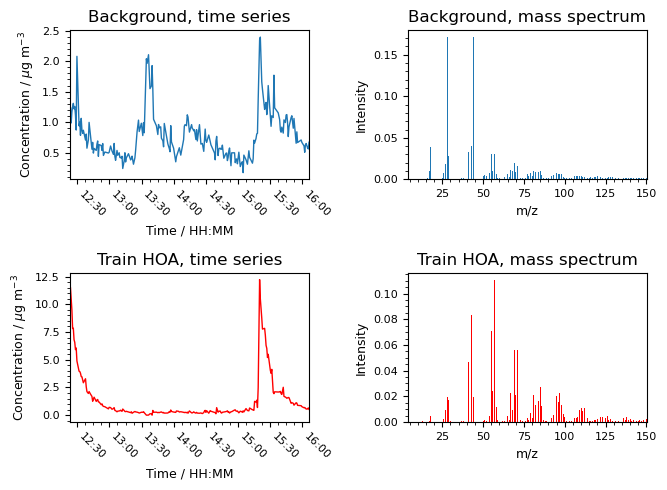

In [6]:
fig, ax = plt.subplots(2, 2, figsize = (6.7, 5))

plot_total(ax[0][0], SoFi['Tinatinv4_2022-03-08'], 'background', 'tab:blue', '-')
ax[0][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = 'Background, time series')
plot_MS(ax[0][1], SoFi['Tinatinv4_2factor_profile'], 'background', 0.5, 'Background, mass spectrum', 'tab:blue')

plot_total(ax[1][0], SoFi['Tinatinv4_2022-03-08'], 'train HOA', 'r', '-')
ax[1][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = 'Train HOA, time series')
plot_MS(ax[1][1], SoFi['Tinatinv4_2factor_profile'], 'train HOA', 0.5, 'Train HOA, mass spectrum', 'r')

fig.tight_layout()
fig.savefig('SoFi/Tinatin_PMF.png', dpi = 600)
plt.show()

In [7]:
def PMF_MS_validation(axes, PMF_df, PMF_key, Ref_dict, Ref_dict_keys, Ref_df_keys, markers, marker_colors):
    for i, key in enumerate(Ref_dict_keys):
        merged = pd.merge(PMF_df, Ref_dict[key], on = 'm/z')
        PMF_total_int, Ref_total_int = pd.to_numeric(merged[PMF_key], errors = 'coerce').sum(), pd.to_numeric(merged[Ref_df_keys[i]], errors = 'coerce').sum()
        merged['PMF scaled'] = pd.to_numeric(merged[PMF_key], errors = 'coerce') / PMF_total_int
        merged['Ref scaled'] = pd.to_numeric(merged[Ref_df_keys[i]], errors = 'coerce') / Ref_total_int

        max_PMF, max_Ref = max(merged['PMF scaled']), max(merged['Ref scaled'])
        if max_PMF > max_Ref:
            x_plot = np.linspace(0, max_PMF + 0.1*max_PMF, 200)
        else:
            x_plot = np.linspace(0, max_Ref + 0.1*max_Ref, 200)
        axes[i].plot(x_plot, x_plot, color = 'grey', lw = 1, ls = '--')

        fit_params, fit_errors, Ndof_fit, squares_fit, R2 = linear_fit(merged['PMF scaled'], merged['Ref scaled'], linear, a_guess = 1, b_guess = 0)
        y_fit = linear(x_plot, *fit_params)

        axes[i].plot(x_plot, y_fit, label = 'Fit', color = 'k', lw = 1.2)
        axes[i].scatter(merged['PMF scaled'], merged['Ref scaled'], s = 10, c = 'blue', label = None)

        for idx, row in merged.iterrows():
            for color, marker in zip(marker_colors, markers):
                if marker == row['m/z']:
                    axes[i].scatter(row['PMF scaled'], row['Ref scaled'], color = color, s = 15)

        axes[i].legend()

        print(f'{key}: ({fit_params[0]:.3f} +- {fit_errors[0]:.4f})x + ({fit_params[1]:.3f} +- {fit_errors[1]:.4f}), R2 = {R2}')

    return axes

In [8]:
HOA_markers = [41, 43, 55, 57]
BBOA_markers = [60, 73]
OOA_markers = [29, 30, 31]
marker_colors = ['orange', 'forestgreen', 'tab:red', 'deepskyblue']

002_HOA: (0.532 +- 5.4088)x + (0.003 +- 0.0903), R2 = 0.2156361972902708
011_HOA: (0.223 +- 5.4090)x + (0.008 +- 0.1130), R2 = 0.016613234774652104
014_HOA: (0.678 +- 5.4088)x + (0.002 +- 0.0903), R2 = 0.4638082096190963


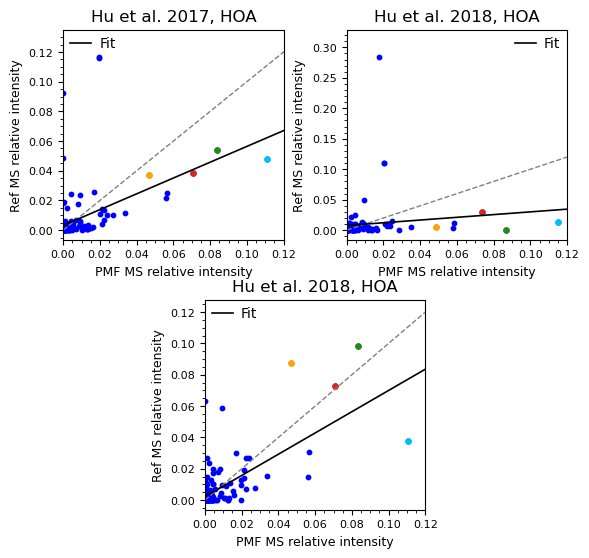

In [16]:
fig = plt.figure(figsize=(6.3, 6))
# Top-left subplot
ax1 = fig.add_axes([0.1, 0.55, 0.35, 0.35])  # [left, bottom, width, height]
# Top-right subplot
ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
# Bottom-center subplot (same size as above, centered)
ax3 = fig.add_axes([0.325, 0.1, 0.35, 0.35])
axes = np.array([ax1, ax2, ax3])

Ref_df_keys = ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']

titles = ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA']

PMF_MS_validation(axes, SoFi['Tinatinv4_2factor_profile'], 'train HOA', Ref_MS, Ref_keys[:3], Ref_df_keys, HOA_markers, marker_colors)

for ax, ttl in zip(axes, titles):
    ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, 0.12))

fig.tight_layout()
fig.savefig('SoFi/PMF_tinatin_trainHOAvsRef.png', dpi = 600)
plt.show()

002_HOA: (0.711 +- 4.0250)x + (0.002 +- 0.0869), R2 = 0.6954135811252389
011_HOA: (0.679 +- 3.9562)x + (0.003 +- 0.1069), R2 = 0.28653740500398284
014_HOA: (0.182 +- 4.0250)x + (0.006 +- 0.0869), R2 = 0.06050095706692031
003_OOA: (1.170 +- 4.0250)x + (-0.001 +- 0.0869), R2 = 0.8325132079643123
007_LO-OOA: (1.181 +- 3.9235)x + (-0.002 +- 0.1113), R2 = 0.9262021932043114
010_LO-OOA: (1.610 +- 3.9562)x + (-0.006 +- 0.1069), R2 = 0.9372001195110674


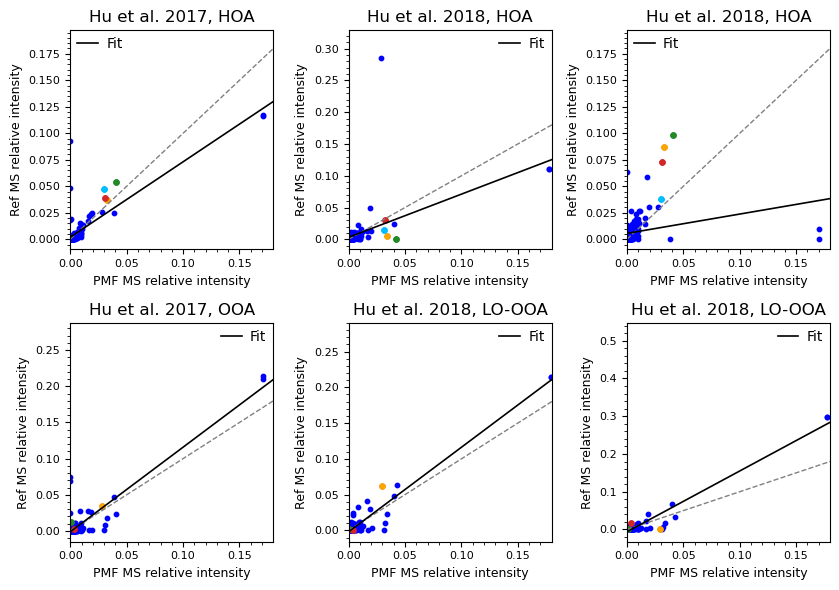

In [10]:
fig, axes = plt.subplots(2, 3, figsize = (8.5, 6))

Ref_df_keys_HOA = ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']
Ref_df_keys_LOOOA = ['OOA total (003)', 'Intensity (007)', 'Intensity (010)']

titles = ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA']

PMF_MS_validation(axes[0], SoFi['Tinatinv4_2factor_profile'], 'background', Ref_MS, Ref_keys[:3], Ref_df_keys_HOA, HOA_markers, marker_colors)
PMF_MS_validation(axes[1], SoFi['Tinatinv4_2factor_profile'], 'background', Ref_MS, Ref_keys[3:6], Ref_df_keys_LOOOA, OOA_markers, marker_colors[:3])

for ax, ttl in zip(axes.flatten(), titles):
    ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, 0.18))

fig.tight_layout()
fig.savefig('SoFi/PMF_tinatin_BGvsRef.png', dpi = 600)
plt.show()

002_HOA: (0.502 +- 4.8157)x + (0.003 +- 0.0887), R2 = 0.24203946512856586
011_HOA: (0.227 +- 4.8048)x + (0.008 +- 0.1103), R2 = 0.021820673292958493
014_HOA: (0.609 +- 4.8157)x + (0.003 +- 0.0887), R2 = 0.47143601460156226


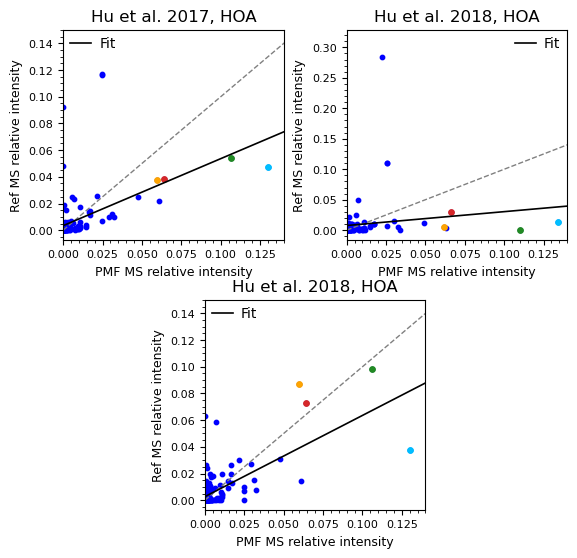

002_HOA: (0.738 +- 4.1193)x + (0.002 +- 0.0871), R2 = 0.7145077478162914
011_HOA: (0.549 +- 4.1224)x + (0.004 +- 0.1075), R2 = 0.172509148394275
014_HOA: (0.282 +- 4.1193)x + (0.005 +- 0.0871), R2 = 0.13826602260527057


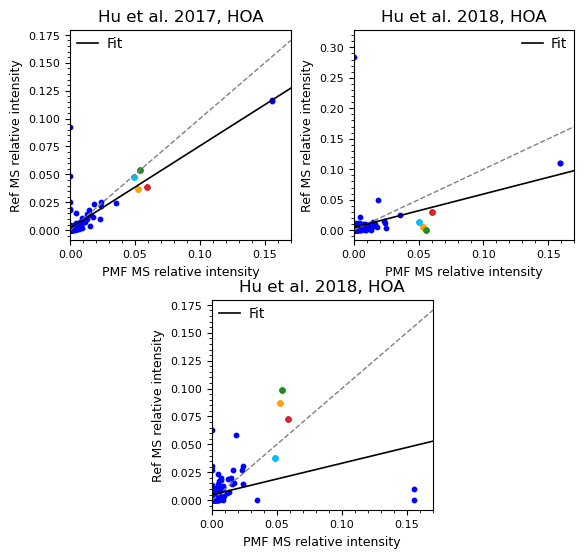

030_Birchen: (1.012 +- 7.3713)x + (0.000 +- 0.1071), R2 = 0.8899718726608129
039_Oak: (1.306 +- 7.3713)x + (-0.002 +- 0.1071), R2 = 0.8086543975233051
041_Pinetree: (1.184 +- 7.3713)x + (-0.001 +- 0.1071), R2 = 0.9052911287420952
042_Poplar: (1.065 +- 7.3713)x + (0.000 +- 0.1071), R2 = 0.8443816342894814


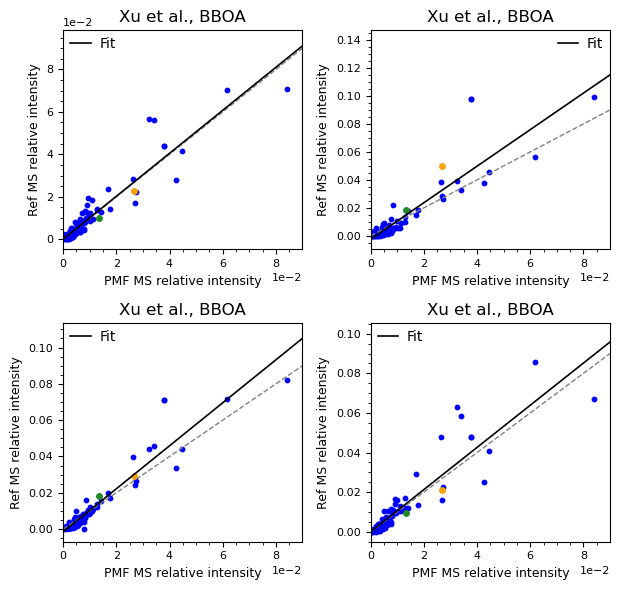

003_OOA: (0.913 +- 3.1325)x + (0.000 +- 0.0852), R2 = 0.8265609018864053
007_LO-OOA: (0.967 +- 3.1799)x + (0.000 +- 0.1085), R2 = 0.9377354145135779
010_LO-OOA: (1.236 +- 3.1733)x + (-0.002 +- 0.1043), R2 = 0.8583295132804674


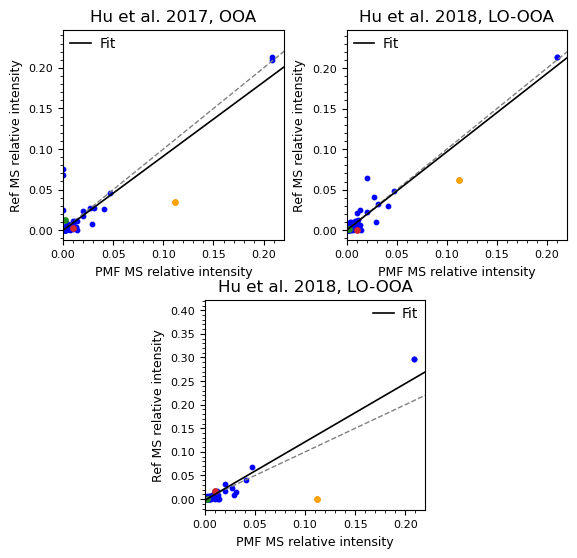

005_MO-OOA: (1.085 +- 2.6649)x + (-0.000 +- 0.1070), R2 = 0.9849819058254855
009_MO-OOA: (1.067 +- 2.6666)x + (-0.000 +- 0.1029), R2 = 0.9909400352467485
012_MO-OOA: (1.053 +- 2.6719)x + (-0.000 +- 0.0845), R2 = 0.9665957448479348


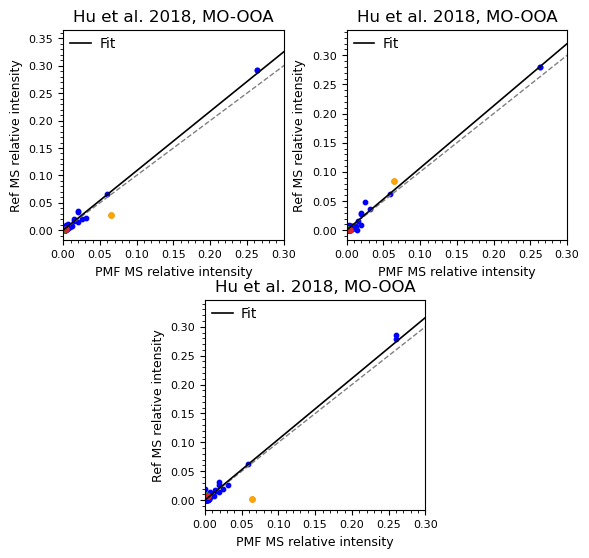

In [21]:
Ref_keys_5factor = [Ref_keys[:3], Ref_keys[:3], Ref_keys[9:], Ref_keys[3:6], Ref_keys[6:9]]
Factors = ['Train HOA', 'Traffic HOA', 'BBOA', 'LO-OOA', 'MO-OOA']
titles = [['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA'],
          ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA'],
          ['Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA'],
          ['Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA'],
          ['Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA']]
Ref_df_keys = [['HOA_total (002)', 'Intensity (011)', 'HOA total (014)'],
               ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)'],
               ['Intensity (030)', 'Intensity (039)', 'Intensity (041)', 'Intensity (042)'],
               ['OOA total (003)', 'Intensity (007)', 'Intensity (010)'],
               ['Intensity (005)', 'Intensity (009)', 'MO-OOA total (012)']]
markers = [[41, 43, 55, 57], # HOA
           [41, 43, 55, 57], # HOA
           [60, 73],         # BBOA
           [29, 30, 31],     # LO-OOA
           [29, 30, 31]]     # MO-OOA

marker_colors = ['orange', 'forestgreen', 'tab:red', 'deepskyblue']
x_max = [0.14, 0.17, 0.09, 0.22, 0.3]

for i in range(5):
    if len(Ref_df_keys[i]) == 3:
        fig = plt.figure(figsize=(6.3, 6))
        # Top-left subplot
        ax1 = fig.add_axes([0.1, 0.55, 0.35, 0.35])  # [left, bottom, width, height]
        # Top-right subplot
        ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
        # Bottom-center subplot (same size as above, centered)
        ax3 = fig.add_axes([0.325, 0.1, 0.35, 0.35])
        axes = np.array([ax1, ax2, ax3])
    if len(Ref_df_keys[i]) == 4:
        fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

    factor = f'Factor{i+1}'

    PMF_MS_validation(axes.flatten(), SoFi['KBHH2024v15_5factor_profile'], factor, Ref_MS, Ref_keys_5factor[i], Ref_df_keys[i], markers[i], marker_colors[:len(markers[i])])

    for ax, ttl in zip(axes.flatten(), titles[i]):
        ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, x_max[i]))

    fig.tight_layout()
    fig.savefig(f'SoFi/PMF_KBHH2024v15_{Factors[i]}vsRef.png', dpi = 600)
    plt.show()

In [32]:
PMF_5factor_scaled = pd.DataFrame({'m/z': SoFi['KBHH2024v15_5factor_profile']['m/z']})
for i in range(5):
    factor = f'Factor{i+1}'
    total_int = pd.to_numeric(SoFi['KBHH2024v15_5factor_profile'][factor], errors = 'coerce').sum()
    PMF_5factor_scaled[factor] = pd.to_numeric(SoFi['KBHH2024v15_5factor_profile'][factor], errors = 'coerce') / total_int

Train_HOA = []
Traffic_HOA = []
BBOA = []
LO_OOA = []
MO_OOA = []
for idx, row in PMF_5factor_scaled.iterrows():
    for marker in [29, 30, 31, 41, 43, 44, 55, 57, 60, 73]:
        if marker == row['m/z']:
            Train_HOA.append(row['Factor1'])
            Traffic_HOA.append(row['Factor2'])
            BBOA.append(row['Factor3'])
            LO_OOA.append(row['Factor4'])
            MO_OOA.append(row['Factor5'])

# HOA
train_4143, traffic_4143 = Train_HOA[3]/Train_HOA[4], Traffic_HOA[3]/Traffic_HOA[4]
train_5557, traffic_5557 = Train_HOA[6]/Train_HOA[7], Traffic_HOA[6]/Traffic_HOA[7]
print(f'Train HOA: f41/f43 = {train_4143:.3f}, f55/f57 = {train_5557:.3f}')
print(f'Traffic HOA: f41/f43 = {traffic_4143:.3f}, f55/f57 = {traffic_5557:.3f}')
# BBOA
bboa_6073 = BBOA[8]/BBOA[9]
print(f'BBOA: f60/f73 = {bboa_6073:.3f}')
# OOA
LO_4443, MO_4443 = LO_OOA[5]/LO_OOA[6], MO_OOA[5]/MO_OOA[6]
print(f'f44/f43: LO-OOA = {LO_4443:.3f}, MO-OOA = {MO_4443:.3f}')
# LO-OOA vs. MO-OOA
LO_MO = np.array(LO_OOA[:3])/np.array(MO_OOA[:3])
print(f'LO-OOA vs. MO-OOA: f29 = {LO_MO[0]:.3f}, f30 = {LO_MO[1]:.3f}, f31 = {LO_MO[2]}')
# BBOA vs. other factors
BBOA_Train = np.array(BBOA[8:])/np.array(Train_HOA[8:])
BBOA_Traffic = np.array(BBOA[8:])/np.array(Traffic_HOA[8:])
BBOA_LO = np.array(BBOA[8:])/np.array(LO_OOA[8:])
BBOA_MO = np.array(BBOA[8:])/np.array(MO_OOA[8:])
print(f'BBOA vs Train HOA: f60 = {BBOA_Train[0]:.3f}, f73 = {BBOA_Train[1]:.3f}')
print(f'BBOA vs Traffic HOA: f60 = {BBOA_Traffic[0]:.3f}, f73 = {BBOA_Traffic[1]:.3f}')
print(f'BBOA vs LO-OOA: f60 = {BBOA_LO[0]:.3f}, f73 = {BBOA_LO[1]:.3f}')
print(f'BBOA vs MO-OOA: f60 = {BBOA_MO[0]:.3f}, f73 = {BBOA_MO[1]:.3f}')

Train HOA: f41/f43 = 0.559, f55/f57 = 0.494
Traffic HOA: f41/f43 = 0.969, f55/f57 = 1.205
BBOA: f60/f73 = 2.010
f44/f43: LO-OOA = 7.173, MO-OOA = 21.449
LO-OOA vs. MO-OOA: f29 = 1.764, f30 = 1.878, f31 = 2.5140426170678194
BBOA vs Train HOA: f60 = 127.419, f73 = 8.799
BBOA vs Traffic HOA: f60 = inf, f73 = 4.815
BBOA vs LO-OOA: f60 = 1.913, f73 = 2.067
BBOA vs MO-OOA: f60 = inf, f73 = 19.573


003_OOA: (0.906 +- 3.0694)x + (0.000 +- 0.0851), R2 = 0.8484259677877216
007_LO-OOA: (0.954 +- 3.1094)x + (-0.000 +- 0.1083), R2 = 0.9516400740327725
010_LO-OOA: (1.235 +- 3.1045)x + (-0.002 +- 0.1041), R2 = 0.8960554102621795


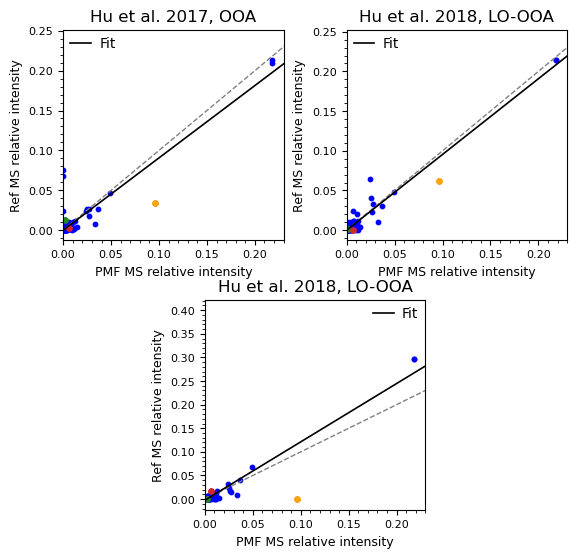

005_MO-OOA: (1.145 +- 2.8011)x + (-0.002 +- 0.1074), R2 = 0.9825300851480013
009_MO-OOA: (1.127 +- 2.8057)x + (-0.001 +- 0.1033), R2 = 0.9914977619276082
012_MO-OOA: (1.106 +- 2.8162)x + (-0.000 +- 0.0847), R2 = 0.9642498273643562


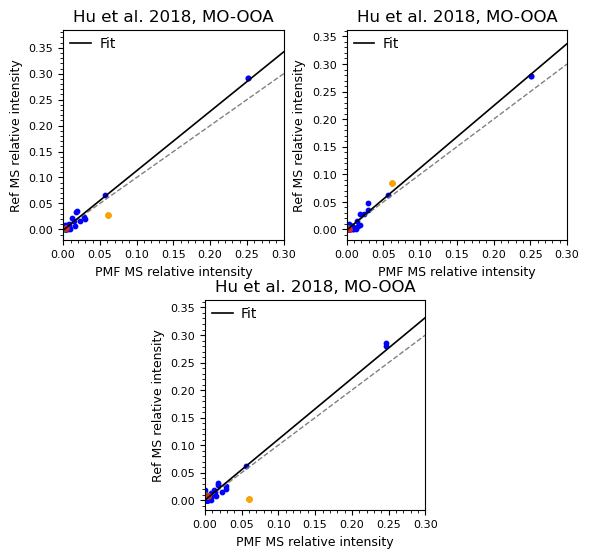

030_Birchen: (1.086 +- 8.1023)x + (0.000 +- 0.1105), R2 = 0.9096954447439718
039_Oak: (1.407 +- 8.1023)x + (-0.003 +- 0.1105), R2 = 0.7774629792097513
041_Pinetree: (1.291 +- 8.1023)x + (-0.002 +- 0.1105), R2 = 0.8911248779658839
042_Poplar: (1.219 +- 8.1023)x + (-0.002 +- 0.1105), R2 = 0.8698623446424018


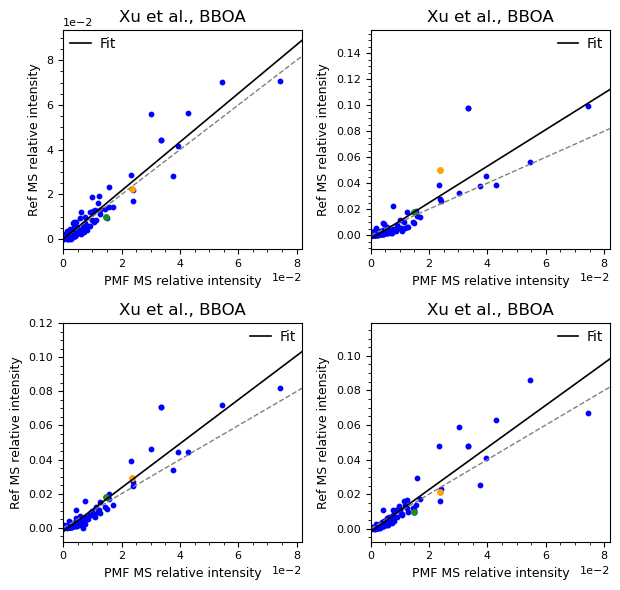

002_HOA: (0.796 +- 4.4374)x + (0.001 +- 0.0878), R2 = 0.7170432893508512
011_HOA: (0.551 +- 4.4392)x + (0.004 +- 0.1088), R2 = 0.15022470646583455
014_HOA: (0.357 +- 4.4374)x + (0.004 +- 0.0878), R2 = 0.19126196382450542


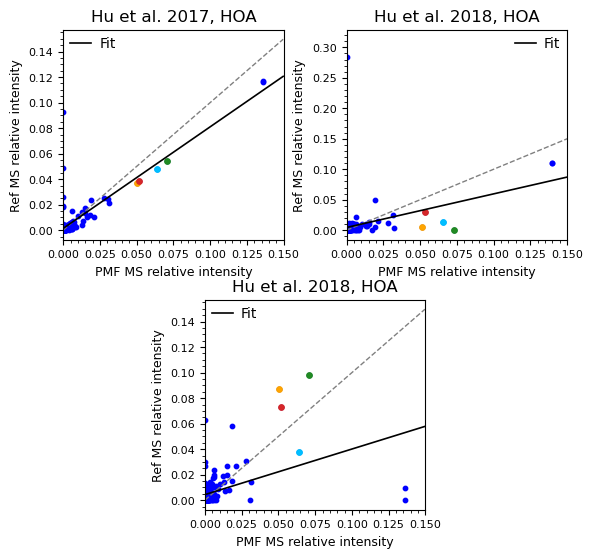

In [25]:
Ref_keys_4factor = [Ref_keys[3:6], Ref_keys[6:9], Ref_keys[9:], Ref_keys[:3]]
Factors = ['LO-OOA', 'MO-OOA', 'BBOA', 'Traffic HOA']
titles = [['Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA'],
          ['Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA'],
          ['Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA'],
          ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA']]
Ref_df_keys = [['OOA total (003)', 'Intensity (007)', 'Intensity (010)'],
               ['Intensity (005)', 'Intensity (009)', 'MO-OOA total (012)'],
               ['Intensity (030)', 'Intensity (039)', 'Intensity (041)', 'Intensity (042)'],
               ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']]
markers = [[29, 30, 31],     # LO-OOA
           [29, 30, 31],     # MO-OOA
           [60, 73],         # BBOA
           [41, 43, 55, 57]] # HOA
           

marker_colors = ['orange', 'forestgreen', 'tab:red', 'deepskyblue']
x_max = [0.23, 0.3, 0.082, 0.15]

for i in range(4):
    if len(Ref_df_keys[i]) == 3:
        fig = plt.figure(figsize=(6.3, 6))
        # Top-left subplot
        ax1 = fig.add_axes([0.1, 0.55, 0.35, 0.35])  # [left, bottom, width, height]
        # Top-right subplot
        ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
        # Bottom-center subplot (same size as above, centered)
        ax3 = fig.add_axes([0.325, 0.1, 0.35, 0.35])
        axes = np.array([ax1, ax2, ax3])
    if len(Ref_df_keys[i]) == 4:
        fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

    factor = f'Factor{i+1}'

    PMF_MS_validation(axes.flatten(), SoFi['KBHH2024v12_4factor_profile'], factor, Ref_MS, Ref_keys_4factor[i], Ref_df_keys[i], markers[i], marker_colors[:len(markers[i])])

    for ax, ttl in zip(axes.flatten(), titles[i]):
        ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, x_max[i]))

    fig.tight_layout()
    fig.savefig(f'SoFi/PMF_KBHH2024v12_{Factors[i]}vsRef.png', dpi = 600)
    plt.show()